<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Homework Template: Earth Analytics Python Course: Spring 2020

Before submitting this assignment, be sure to restart the kernel and run all cells. To do this, pull down the Kernel drop down at the top of this notebook. Then select **restart and run all**.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below.

* IMPORTANT: Before you submit your notebook, restart the kernel and run all! Your first cell in the notebook should be `[1]` and all cells should run in order! You will lose points if your notebook does not run. 

For all plots and code in general:

* Add appropriate titles to your plot that clearly and concisely describe what the plot shows (e.g. time, location, phenomenon).
* Be sure to use the correct bands for each plot.
* Specify the source of the data for each plot using a plot caption created with `ax.text()`.
* Place ONLY the code needed to create a plot in the plot cells. Place additional processing code ABOVE that cell (in a separate code cell).

Make sure that you:

* **Only include the package imports, code, data, and outputs that are CRUCIAL to your homework assignment.**
* Follow PEP 8 standards. Use the `pep8` tool in Jupyter Notebook to ensure proper formatting (however, note that it does not catch everything!).
* Keep comments concise and strategic. Don't comment every line!
* Organize your code in a way that makes it easy to follow. 
* Write your code so that it can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible.
   2. all paths should be created dynamically using the os package to ensure that they work across operating systems. 
* Check for spelling errors in your text and code comments


In [1]:
NAME = "Richard Udell"
COLLABORATORS = ""

![Colored Bar](colored-bar.png)

{% include toc title="This Week" icon="file-text" %}

<div class="notice--info" markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Welcome to Week {{ page.week }}!

Welcome to week {{ page.week }} of Earth Analytics! This week you will learn how to automate a workflow using `Python`. You will design and implement your own workflow in `Python` that builds on the skills that you have learned in this course, such as functions and loops. You will also learn how to programmatically build paths to directories and files as well as parse strings to extract information from file and directory names.  

{% include/data_subsets/course_earth_analytics/_data-landsat-automation.md %}


</div>


## Automate a Workflow in Python

For this week’s assignment, you will generate a plot of the normalized difference vegetation index (NDVI) for two different locations in the United States to begin to understand how the growing seasons vary in each site:

1. <a href="https://www.neonscience.org/field-sites/field-sites-map/SJER" target="_blank">San Joaquin Experimental Range (SJER) in Southern California, United States</a>
2. <a href="https://www.neonscience.org/field-sites/field-sites-map/HARV" target="_blank">Harvard Forest (HARV) in the Eastern United States</a> 

From this plot, you will be able to compare the seasonal vegetation patterns of the two locations. This comparison would be useful if you were planning NEON’s upcoming flight season in both locations and wanted to ensure that you flew the area when the vegetation was the most green! If could also be useful if you wanted to track green-up as it happened over time in both sites to see if there were changes happening. 

As a bonus, you will also create a stacked NDVI output data product to share with your colleagues. You are doing all of the work to clean and process the data. It would be nice if you could share a data product output to save others the hassle. 

## Design A Workflow 

Your goal this week is to calculate the mean NDVI value for each Landsat 8 scene captured for a NEON site over a year. You have the following data to do accomplish this goal:

1. One year worth of Landsat 8 data for each site: Remember that for each landsat scene, you have a series of geotiff files representing bands and qa (quality assurance) layers in your data.
2. A site boundary “clip file” for each site: This is a shapefile representing the boundary of each NEON site. You will want to clip your landsat data to this boundary.

Before writing `Python` code, write pseudocode for your implementation. Pseudo-coding means that you will write out all of the steps that you need to perform. Then, you will identify areas where tasks are repeated that could benefit from a function, areas where loops might be appropriate, etc.  


## Homework for this Week

Your homework for this week is provided in the assignment dropbox on Canvas.


## Homework Plots

The plots below are examples of what your output plots will look like with and without dealing with clouds.


In [2]:
# Autograding imports - do not modify this cell

import matplotcheck.autograde as ag
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
from datetime import datetime

In [35]:
# Import necessary packages
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

# Imports for box function?


# Get data and set working directory
data = et.data.get_data('ndvi-automation')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [4]:
# Import SJER site boundary (.shp)
sjer_base_path = os.path.join('data', 'ndvi-automation', 'sites', 'SJER')
sjer_site_boundary_path = os.path.join(
    sjer_base_path, 'vector', 'SJER-crop.shp')
sjer_site_boundary = gpd.read_file(sjer_site_boundary_path, masked=True)

# Import HARV site boundary (.shp)
harv_base_path = os.path.join('data', 'ndvi-automation', 'sites', 'HARV')
harv_site_boundary_path = os.path.join(
    harv_base_path, 'vector', 'HARV-crop.shp')
harv_site_boundary = gpd.read_file(harv_site_boundary_path, masked=True)

In [5]:
# sjer_site_boundary
harv_site_boundary

,id,area_sq_m,geometry
0,1,2.839189e+07,"POLYGON ((730221.371 4709974.218, 730032.194 4..."


In [6]:
# Set file path for SJER glob import
sjer_landsat_dir_path = os.path.join(
    sjer_base_path, 'landsat-crop', 'LC080420342017010701T2-SC20181023153321')
#harv_landsat_path = os.path.join(harv_base_path, 'landsat-crop')

# Execute SJER glob import
sjer_glob = glob(sjer_landsat_dir_path + '/*band*.tif')
sjer_glob.sort()

In [7]:
# Let's take a look at our SJER glob
sjer_glob

['data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017010701T2-SC20181023153321/LC08_L1GT_042034_20170107_20170218_01_T2_sr_band1.tif',
 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017010701T2-SC20181023153321/LC08_L1GT_042034_20170107_20170218_01_T2_sr_band2.tif',
 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017010701T2-SC20181023153321/LC08_L1GT_042034_20170107_20170218_01_T2_sr_band3.tif',
 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017010701T2-SC20181023153321/LC08_L1GT_042034_20170107_20170218_01_T2_sr_band4.tif',
 'data/ndvi-automation/sites/SJER/landsat-crop/LC080420342017010701T2-SC20181023153321/LC08_L1GT_042034_20170107_20170218_01_T2_sr_band5.tif']

In [8]:
# Stack the SJER landsat data glob
sjer_output_path = os.path.join(
    'data', 'ndvi-automation', 'outputs', 'sjer.tif')
sjer_stack, land_meta = es.stack(sjer_glob, sjer_output_path)

In [15]:
# Open the stack function output SJER .tif file
with rio.open(sjer_output_path) as sjer_src:
    sjer_all_bands = sjer_src.read(masked=True)
    sjer_extent = plotting_extent(sjer_src)

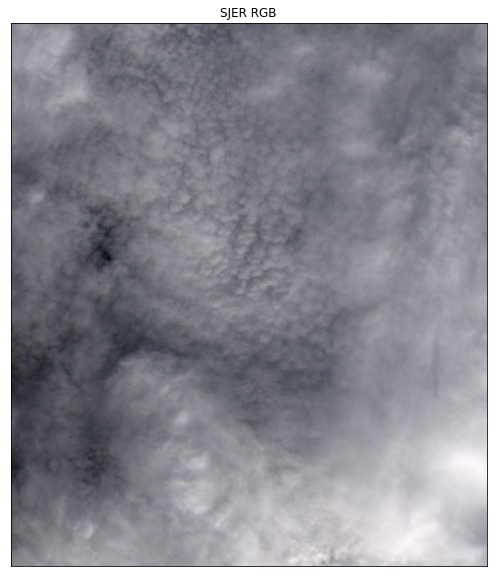

In [17]:
# Plot the stack function output SJER .tif file
ep.plot_rgb(sjer_all_bands, rgb=[3, 2, 1],
            extent=sjer_extent, title="SJER RGB")
plt.show()

### The next step is to figure out how to handle cloud cover
Pseudo code: extract the qa
* set file path to qa.tif
* via context manager - open qa.tif and read qa.tif and extract plotting_extent
    * now explore what we have (pixel_flags column)
* ##### Create a list of values that you want to set as "mask" in the pixel qa layer   
`high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    all_masked_values = cloud_shadow + cloud + high_cloud_confidence`

* 


In [38]:
sjer_qa_path = os.path.join(sjer_base_path, 'landsat-crop', 
                            'LC080420342017010701T2-SC20181023153321',
                            'LC08_L1GT_042034_20170107_20170218_01_T2_pixel_qa.tif')

with rio.open(sjer_qa_path) as sjer_qa_src:
    sjer_qa = sjer_qa_src.read(1)
    sjer_qa_extent = plotting_extent(sjer_qa_src)

In [45]:
qa_classes = np.unique(sjer_qa).tolist()

In [46]:
qa_classes

[992]

In [40]:
# Let's try and plot the pixel qa layer

# This is optional code to plot the qa layer - don't worry too much about the details.
# Create a colormap with 11 colors
cmap = plt.cm.get_cmap('tab20b', 11)
# Get a list of unique values in the qa layer
vals = np.unique(sjer_qa).tolist()
bins = [0] + vals
# Normalize the colormap 
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(sjer_qa,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap, 
               titles=vals)

ax.set_title("Landsat Collection Quality Assessment Layer")
ax.set_axis_off()
plt.show()

ZeroDivisionError: division by zero

ZeroDivisionError: division by zero

<Figure size 864x576 with 1 Axes>

In [12]:
# Test your dataframe! For each test, rename the dataframe comparison to check against your dataframe.

# For example, in test one, the date test, change "student_dataframe['date_column']" to match
# your dataframe's name and date column. If your dataframe was called ndvi_data and the dates column was named
# date_time, than the lines should look like `assert date_series.equals(ndvi_data['date_time'].sort_values())`

# These tests are not graded so if they fail but your graph is correct
# you won't be docked any points! Leave the sort values statement, only replace the dataframe and column names.

# This is for data that hasn't been masked yet, it should be a half way sanity check.

try:
    assert site_series.equals(ndvi_ts['site'].sort_values())
    print('Your site names appear to be accurate!')
except AssertionError:
    print('There seems to be an issue with your site names, check that column to make sure the values are correct.')
try:
    assert date_series.equals(ndvi_ts['date'].sort_values())
    print('Your date values appear to be accurate!')
except AssertionError:
    print('There seems to be an issue with your date values, check that column to make sure the values are correct.')
try:
    assert ndvi_series.equals(ndvi_ts['ndvi'].sort_values())
    print('Your ndvi values appear to be accurate!')
except AssertionError:
    print('There seems to be an issue with your ndvi values, check that column to make sure the values are correct.')

NameError: name 'site_series' is not defined

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### DO NOT REMOVE LINE BELOW ###
final_masked_solution = nb.convert_axes(plt, which_axes="current")